In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
from lib.controllers import PIController
%matplotlib inline

We will simulate a first order plus dead time system under PI control

In [2]:
# This is the 1,1 element of a Wood and Berry column (see eq 16-12)
K = 12.8
tau = 16.7
theta = 1

In [3]:
ts = numpy.linspace(0, 2*tau, 500)
dt = ts[1]
r = 1

In [4]:
def response(Kc, tau_i):
    Gc = PIController(Kc, tau_i, bias=0)
    y = 0
    ys = numpy.zeros_like(ts)

    for i, t in enumerate(ts):
        e = r - numpy.interp(t - theta, ts, ys)
        
        Gc.change_input(t, e)
        u = Gc.output

        dydt = -1/tau*y + K/tau*u

        # integrate
        y += dydt*dt
        Gc.change_state(Gc.x + Gc.derivative*dt)

        ys[i] = y
    return ys

What does the setpoint response look like?

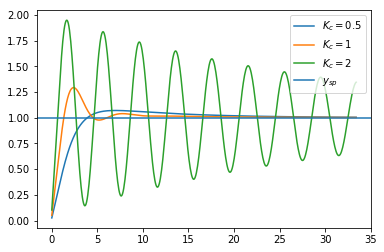

In [6]:
for Kc in [0.5, 1, 2]:
    plt.plot(ts, response(Kc, 10), label='$K_c={}$'.format(Kc))
plt.axhline(r, label='$y_{sp}$')
plt.legend()

These are the error measures in the book (eq 11-35 to 11-37). Note that the syntax `f(*parameters)` with `parameters=(1, 2)` is equivalent to `f(1, 2)`. 

In [7]:
def iae(parameters):
    return scipy.integrate.trapz(numpy.abs(response(*parameters) - r), ts)

In [8]:
def ise(parameters):
    return scipy.integrate.trapz((response(*parameters) - r)**2, ts)

In [9]:
def itae(parameters):
    return scipy.integrate.trapz(numpy.abs(response(*parameters) - r)*ts, ts)

In [10]:
errfuns = [iae, ise, itae]

Now we can find the optimal parameters for the various error measures. Note that this step takes a very long time to run (>10 minutes on my computer).

In [ ]:
%%time
optimal_parameters = {}
for error in errfuns:
    name = error.__name__.upper()
    optimal_parameters[name] = scipy.optimize.minimize(error, [1, 10]).x
    print(name, *optimal_parameters[name])
    plt.plot(ts, response(*optimal_parameters[name]), label=name)
plt.axhline(1, label='setpoint')
plt.legend(loc='best')

IAE 0.80526482842 16.7002801797
ISE 1.04698004367 25.4750682969


In table 11.3, we find the following design relations for ITAE:

In [ ]:
A, B = 0.586, -0.916
Kc = A*(theta/tau)**B/K
A, B = 1.03, -0.165
tau_i = tau/(A + B*(theta/tau))

print(Kc, tau_i)

These values correspond with those found through direct minimisation.

In [ ]:
plt.plot(ts, response(Kc, tau_i))